(chapter1_part7)=

# Full Pipeline of the Two-level Recommender System

In this chapter, we will wrap up all steps from 1.2 to 1.5:
- Preprocess data with proper two-level validation;
- Develop candidate generation model with implicit library;
- Then, move to Catboost and get our reranker - second level model;
- Finally, evaluate our models: implicit vs implicit + reranker

First, let's recall what we discussed in [`Metrics & Validation`](https://rekkobook.com/chapter1/validation_metrics.html)
In recommender systems we have special data split to validate our model - we split data by time for candidates
and by users for reranker. Now, we move on to coding.

# 0. Configuration

In [1]:
# KION DATA
INTERACTIONS_PATH = 'https://drive.google.com/file/d/1MomVjEwY2tPJ845zuHeTPt1l53GX2UKd/view?usp=share_link'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/1XGLUhHpwr0NxU7T4vYNRyaqwSK5HU3N4/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MCTl6hlhFYer1BTwjzIBfdBZdDS_mK8e/view?usp=share_link'

# 1. Modules and functions

In [2]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/home/runner/.cache/pypoetry/virtualenvs/rekko-handbook-y_Nwlfrq-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?


"is not" with a literal. Did you mean "!="?


## 1. 1. Helper functions to avoid copy paste

In [3]:
def read_parquet_from_gdrive(url, engine: str = 'pyarrow'):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_parquet(file_path, engine = engine)

    return data

# 2. Main
## 2.1. Load and preprocess data
`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion

In [4]:
# interactions data
interactions = read_parquet_from_gdrive(INTERACTIONS_PATH)
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform

In [5]:
# information about films etc
movies_metadata = read_parquet_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.000,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000,None,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.000,"зарубежные, приключения, комедии",США,NaN,16.000,None,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.000,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.000,None,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


`users_data` contains basic info like gender, age group, income group and kids flag

In [6]:
users_data = read_parquet_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


Now, a bit of preprocessing to avoid noisy data.

In [7]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [8]:
# convert to datetime
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

### 2.1.2. Train / Test split

As we dicussed in Validation and metrics [chapter], we need time based split for candidates generation
to avoid look-ahead bias. Therefor, let's set date thresholds

In [9]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 14
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")
print(f"test max date to split:: {TEST_MAX_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00
test max date to split:: 2021-08-08 00:00:00


In [10]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

global_train = global_train.dropna().reset_index(drop = True)
print(global_train.shape, global_test.shape)

(3530223, 5) (665015, 5)


Here, we define "local" train and test to use some part of the global train for ranker

In [11]:
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')

print(local_train_thresh)

2021-07-11 00:00:00


In [12]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2451040, 5)

 (1079183, 5)


Final filter, we will focus on warm start -- remove cold start users

In [13]:
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(579382, 5)


### 2.1.2 LightFM Dataset setup
LightFM provides built-in Dataset class to work with and use in fitting the model.

In [14]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

Next, we will need mappers as usual, but with lightfm everything is easier and can be
extracted from initiated data class `dataset`

In [15]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  539173
user features mapper length -  539173
movies mapper length -  13006
Users movie features mapper length -  13006


In [16]:
# inverted mappers to check recommendations
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [17]:
# crate mapper for movie_id and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [18]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)


Finally, built dataset using `user_id` & `item_id`

In [19]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [20]:
train_mat

<539173x13006 sparse matrix of type '<class 'numpy.int32'>'
	with 2451040 stored elements in COOrdinate format>

In [21]:
train_mat_weights

<539173x13006 sparse matrix of type '<class 'numpy.float32'>'
	with 2451040 stored elements in COOrdinate format>

## 2.2. Fit the model

Set some default parameters for the model

In [22]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [23]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

Run training pipeline

In [24]:
# execute training
for _ in tqdm(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:04<01:26,  4.56s/it]

 10%|█         | 2/20 [00:07<01:04,  3.58s/it]

 15%|█▌        | 3/20 [00:10<00:53,  3.16s/it]

 20%|██        | 4/20 [00:12<00:46,  2.89s/it]

 25%|██▌       | 5/20 [00:14<00:40,  2.71s/it]

 30%|███       | 6/20 [00:17<00:36,  2.57s/it]

 35%|███▌      | 7/20 [00:19<00:32,  2.48s/it]

 40%|████      | 8/20 [00:21<00:28,  2.40s/it]

 45%|████▌     | 9/20 [00:24<00:25,  2.34s/it]

 50%|█████     | 10/20 [00:26<00:22,  2.29s/it]

 55%|█████▌    | 11/20 [00:28<00:20,  2.24s/it]

 60%|██████    | 12/20 [00:30<00:17,  2.20s/it]

 65%|██████▌   | 13/20 [00:32<00:15,  2.17s/it]

 70%|███████   | 14/20 [00:34<00:12,  2.14s/it]

 75%|███████▌  | 15/20 [00:36<00:10,  2.11s/it]

 80%|████████  | 16/20 [00:38<00:08,  2.09s/it]

 85%|████████▌ | 17/20 [00:40<00:06,  2.07s/it]

 90%|█████████ | 18/20 [00:42<00:04,  2.05s/it]

 95%|█████████▌| 19/20 [00:44<00:02,  2.03s/it]

100%|██████████| 20/20 [00:46<00:00,  2.02s/it]

100%|██████████| 20/20 [00:46<00:00,  2.33s/it]

Let's make sense-check on the output model

In [25]:
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 713676, row number in matrix - 62


In [26]:
# item indices
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

# predictions
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

# sort and final postprocessing
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 20, 302, 435, 298, 146,   5, 232, 225,  78, 342])

In [27]:
# pandas dataframe for convenience
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,20,7626,Мстители: Война бесконечности
1,302,12173,Мстители: Финал
2,435,13018,Король лев (2019)
3,298,13915,Вперёд
4,146,11310,Аладдин
5,5,7571,100% волк
6,232,1785,Чёрная пантера
7,225,10942,Мстители
8,78,12501,Во всё тяжкое
9,342,5754,Доктор Стрэндж


In the end, we need to make predictions on all `local_test` users to use this sample to train reranker model.
As I have mentioned earlier, in reranker we split randomly by users.

In [28]:
# make predictions for all users in test
local_test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(local_test_preds)

144739

In [29]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [30]:
# init mapper to get predictions
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [31]:
# get predictions
local_test_preds['item_id'] = local_test_preds['user_id'].map(mapper)

Prettify predictions to use in catboost - make list to rows and add rank

In [32]:
local_test_preds = local_test_preds.explode('item_id')
local_test_preds['rank'] = local_test_preds.groupby('user_id').cumcount() + 1 
local_test_preds['item_name'] = local_test_preds['item_id'].map(item_name_mapper)
print(f'Data shape{local_test_preds.shape}')
local_test_preds.head()

Data shape(1447390, 4)


,user_id,item_id,rank,item_name
0,646903,12173,1,Мстители: Финал
0,646903,7626,2,Мстители: Война бесконечности
0,646903,10440,3,Хрустальный
0,646903,14317,4,Веном
0,646903,16361,5,Doom: Аннигиляция


In [33]:
# sense check for diversity of recommendations
local_test_preds.item_id.nunique()

1733

## 2.3. CatBoostClassifier (ReRanker)
### 2.3.1. Data preparation

We need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [34]:
positive_preds = pd.merge(local_test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(77517, 8)

In [35]:
negative_preds = pd.merge(local_test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(273975, 8)

Random split by users to train reranker

In [36]:
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

Set up train/test set and shuffle samples

In [37]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [38]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [39]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:           user_id       rank   total_dur  watched_pct     target
count  281177.000 281177.000   61809.000    61809.000 281177.000
mean   549025.174      5.294   18553.425       65.355      0.220
std    315996.838      2.885   36147.733       36.837      0.414
min        11.000      1.000     301.000        0.000      0.000
25%    275357.000      3.000    3998.000       25.000      0.000
50%    549650.000      5.000    7785.000       80.000      0.000
75%    821849.000      8.000   22554.000      100.000      0.000
max   1097528.000     10.000 2414017.000      100.000      1.000 
, TEST:           user_id      rank  total_dur  watched_pct    target
count   70315.000 70315.000  15708.000    15708.000 70315.000
mean   550415.321     5.292  18821.116       64.905     0.223
std    317747.234     2.883  35823.491       37.028     0.417
min       106.000     1.000    302.000        0.000     0.000
25%    273625.000     3.000   3823.500       25.000     0.000
50%    552131.000     5.000

In [40]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

Prepare final datasets - joins user and item features

In [41]:
cbm_train_set = pd.merge(cbm_train_set, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])


In [42]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])

print(cbm_train_set.shape, cbm_test_set.shape)

(281177, 16) (70315, 16)


In [43]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,684590,10680,9,Дэдпул 2,NaT,NaN,NaN,0,age_55_64,income_20_40,М,0.000,film,2018.000,NaN,18.000
1,991785,4880,10,Афера,NaT,NaN,NaN,0,age_45_54,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
2,808240,4880,8,Афера,2021-07-25,7498.000,9.000,1,age_25_34,income_20_40,М,0.000,series,2021.000,NaN,18.000
3,1030515,3697,8,Великая,NaT,NaN,NaN,0,age_25_34,income_20_40,Ж,0.000,series,2015.000,NaN,12.000
4,345363,11778,3,Простые сложности,NaT,NaN,NaN,0,age_35_44,income_60_90,М,0.000,film,2009.000,NaN,16.000


Set necessary cols to filter out sample

In [44]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [45]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(281177, 9) (70315, 9)


Fill missing values with mode - just in case by default

In [46]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

### 2.3.2 Train the model

In [47]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [48]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS,
    verbose = False
)

### 2.3.3. Model Evaluation
Let's make basic shapley plot to investigate feature importance. We expect that `rank` - predicted
order from LightFM - must be on top

In [49]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

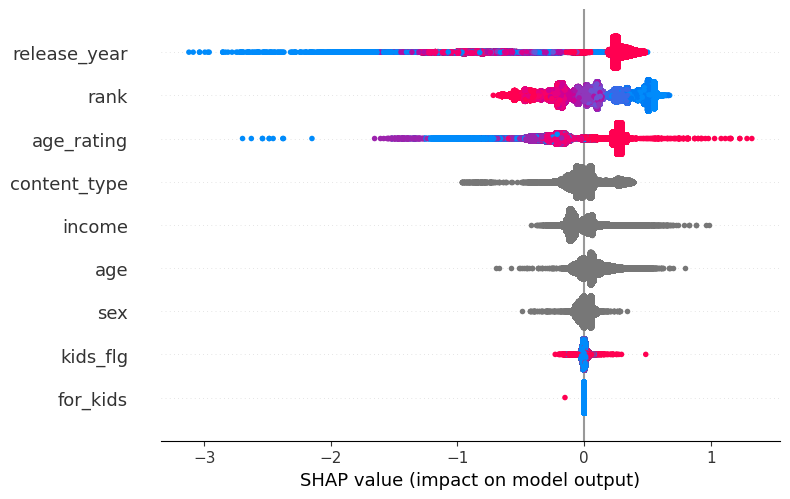

In [50]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

Let's see performance of the classifier

In [51]:
# predictions on test
from sklearn.metrics import roc_auc_score
y_test_pred = cbm_classifier.predict_proba(X_test)

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


### 2.4. Evaluation on global test
Here, we compare predictions of two models - LightFM vs LightFM + CatBoost.
First, let's calculate predictions from both models - here we generate candidates via LightFM.

In [52]:
global_test_predictions = pd.DataFrame({
    'user_id': global_test['user_id'].unique()
        }
    )

# filter out cold start users
global_test_predictions = global_test_predictions.loc[global_test_predictions['user_id'].isin(local_train.user_id.unique())]

In [53]:
# set param for number of candidates
top_k = 100

# generate list of watched titles to filter
watched_movies = local_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = watched_movies,
    N = top_k,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 10
)

global_test_predictions['item_id'] = global_test_predictions['user_id'].map(mapper)
global_test_predictions = global_test_predictions.explode('item_id').reset_index(drop=True)
global_test_predictions['rank'] = global_test_predictions.groupby('user_id').cumcount() + 1 

Now, we can move to reranker to make predictions and make new order.
Beforehand, we need to prepare data for reranker

In [54]:
cbm_global_test = pd.merge(global_test_predictions, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])

cbm_global_test = pd.merge(cbm_global_test, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,203219,10440,1,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
1,203219,13865,2,NaN,NaN,NaN,NaN,film,2021.000,NaN,12.000
2,203219,15297,3,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
3,203219,4880,4,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
4,203219,2657,5,NaN,NaN,NaN,NaN,series,2021.000,NaN,16.000


Fill missing values with the most frequent values

In [55]:
cbm_global_test = cbm_global_test.fillna(cbm_global_test.mode().iloc[0])

Predict scores to get ranks

In [56]:
cbm_global_test['cbm_preds'] = cbm_classifier.predict_proba(cbm_global_test[X_train.columns])[:, 1]
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating,cbm_preds
0,203219,10440,1,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.357
1,203219,13865,2,age_35_44,income_20_40,М,0.000,film,2021.000,0.000,12.000,0.316
2,203219,15297,3,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.289
3,203219,4880,4,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.264
4,203219,2657,5,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,16.000,0.163


In [57]:
# define cbm rank
cbm_global_test = cbm_global_test.sort_values(by = ['user_id', 'cbm_preds'], ascending = [True, False])
cbm_global_test['cbm_rank'] = cbm_global_test.groupby('user_id').cumcount() + 1
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating,cbm_preds,cbm_rank
5673204,14,9728,5,age_35_44,income_20_40,М,0.000,film,2021.000,0.000,18.000,0.368,1
5673200,14,10440,1,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.357,2
5673201,14,15297,2,age_35_44,income_20_40,М,0.000,series,2021.000,0.000,18.000,0.341,3
5673202,14,13865,3,age_35_44,income_20_40,М,0.000,film,2021.000,0.000,12.000,0.327,4
5673205,14,3734,6,age_35_44,income_20_40,М,0.000,film,2021.000,0.000,16.000,0.288,5


Finally, let's move on to comparison
- define function to calculate matrix-based metrics;
- create table of metrics for both models

In [58]:
def calc_metrics(df_true, df_pred, k: int = 10, target_col = 'rank'):
    """
    calculates confusion matrix based metrics
    :df_true: pd.DataFrame
    :df_pred: pd.DataFrame
    :k: int, 
    """
    # prepare dataset
    df = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    df = df.sort_values(by = ['user_id', target_col])
    df['users_watch_count'] = df.groupby(level = 'user_id')[target_col].transform(np.size)
    df['cumulative_rank'] = df.groupby(level = 'user_id').cumcount() + 1
    df['cumulative_rank'] = df['cumulative_rank'] / df[target_col]
    
    # params to calculate metrics
    output = {}
    num_of_users = df.index.get_level_values('user_id').nunique()

    # calc metrics
    df[f'hit@{k}'] = df[target_col] <= k
    output[f'Precision@{k}'] = (df[f'hit@{k}'] / k).sum() / num_of_users
    output[f'Recall@{k}'] = (df[f'hit@{k}'] / df['users_watch_count']).sum() / num_of_users
    output[f'MAP@{k}'] = (df["cumulative_rank"] / df["users_watch_count"]).sum() / num_of_users
    print(f'Calculated metrics for top {k}')
    return output

In [59]:
# first-level only - LightFM
lfm_metrics = calc_metrics(global_test, global_test_predictions)
lfm_metrics

Calculated metrics for top 10


{'Precision@10': 0.009851701327337972,
 'Recall@10': 0.04763977070682585,
 'MAP@10': 0.02363611136814694}

In [60]:
# LightFM + ReRanker
full_pipeline_metrics = calc_metrics(global_test, cbm_global_test, target_col = 'cbm_rank')
full_pipeline_metrics

Calculated metrics for top 10


{'Precision@10': 0.009838730597950625,
 'Recall@10': 0.048187206265326014,
 'MAP@10': 0.025147160865036496}

Prettify both metrics calculation results for convenience

In [61]:
metrics_table = pd.concat(
    [pd.DataFrame([lfm_metrics]),
    pd.DataFrame([full_pipeline_metrics])],
    ignore_index = True
)
metrics_table.index = ['LightFM', 'FullPipeline']

# calc relative diff
metrics_table = metrics_table.append(metrics_table.pct_change().iloc[-1].mul(100).rename('lift_by_ranker, %'))

metrics_table

,Precision@10,Recall@10,MAP@10
LightFM,0.010,0.048,0.024
FullPipeline,0.010,0.048,0.025
"lift_by_ranker, %",-0.132,1.149,6.393


Thus, with a few number of features we could improve our metrics using reranker.
Further, imagine how it can be improved if we add more features and fine tune the reranker

# Source & further recommendations
- [Kaggle Notebook for LightFM](https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook);
- [Recommended course from MTS RecSys team on ods.ai](https://ods.ai/tracks/mts-recsys-df2020)